# Data Cleaning

### 0. Import necessary libraries

In [1]:
import gc
import os
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from tqdm import tqdm_notebook


DATA_FOLDER = '../data/'
d_parser = lambda x: pd.datetime.strptime(x,'%d.%m.%Y')

warnings.filterwarnings("ignore")
import utils

#instantiate the object (all important functions are gathered in this class)
sales_util = utils.SalesUtils('')

### 1. Read the data

In [2]:
%%time

df_sales           = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv'), parse_dates =["date"],date_parser=d_parser)
df_items           = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
df_item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
df_shops           = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))
df_test            = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv'))

Wall time: 1min 44s


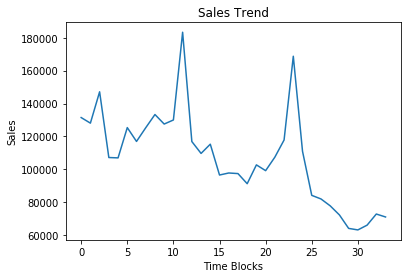

In [4]:
items_sold_per_month = df_sales.groupby('date_block_num')['item_cnt_day'].sum()
plt.plot(items_sold_per_month)
plt.title('Sales Trend')
plt.xlabel('Time Blocks')
plt.ylabel('Sales')
plt.show()

### 2. Check for outliers
Since, the outliers, can be found in item_cnt_day, that is the total quantity sold, and item_price, so will check both

In [3]:
len_test= len(df_test)
len_sales = len(df_sales) 

Outliers for item_cnt_day (greater than 1001):  [2169.]
Outliers for item_cnt_day (less than 0) :  [ -1.  -5.  -6.  -3.  -2.  -4. -22. -16.  -9.]
Wall time: 279 ms


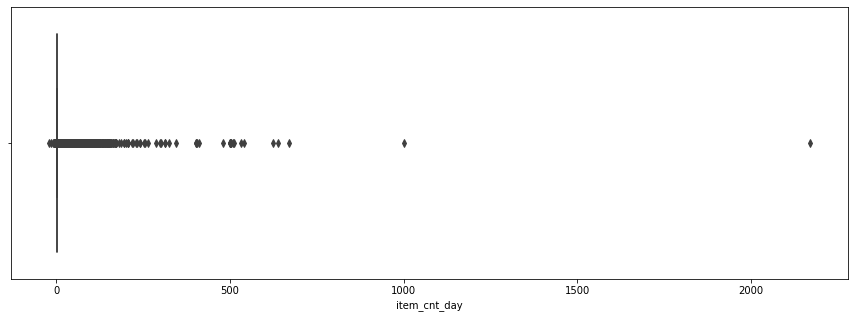

In [9]:
%%time
# for item quantity
plt.figure(figsize=(15,5))
sns.boxplot(x=df_sales['item_cnt_day'])
print('Outliers for item_cnt_day (greater than 1001): ', df_sales[df_sales['item_cnt_day']>1001]['item_cnt_day'].unique())
print('Outliers for item_cnt_day (less than 0) : ', df_sales[df_sales['item_cnt_day']<0]['item_cnt_day'].unique())

Wall time: 612 ms


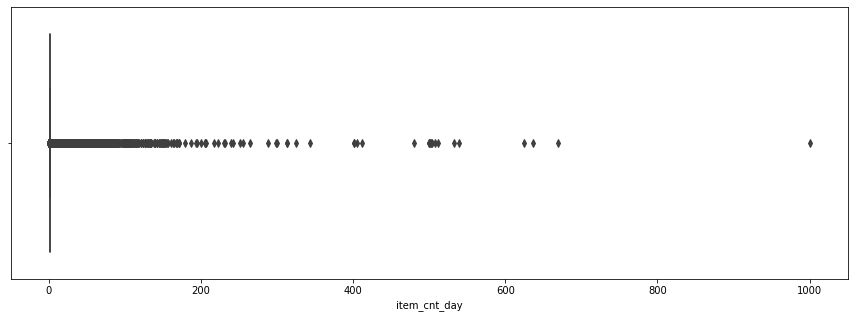

In [11]:
%%time
# deleting the quantities which are greater than 1001
df_sales = df_sales[df_sales['item_cnt_day']<=1001]

#any item_cnt_day which is less than 0 should be 0
df_sales.loc[df_sales.item_cnt_day < 1,'item_cnt_day'] = 0 

plt.figure(figsize=(15,5))
sns.boxplot(x=df_sales['item_cnt_day'])

# Note: To be Tested Later

In [7]:
#df_sales = df_sales[df_sales['item_cnt_day'] <= 1001]
#df_sales = df_sales[df_sales['item_price'] <= 100000]

Outliers for item_price :  [ 59200. 307980.]
Outliers for item_price less than 0 :  [-1.]
Wall time: 285 ms


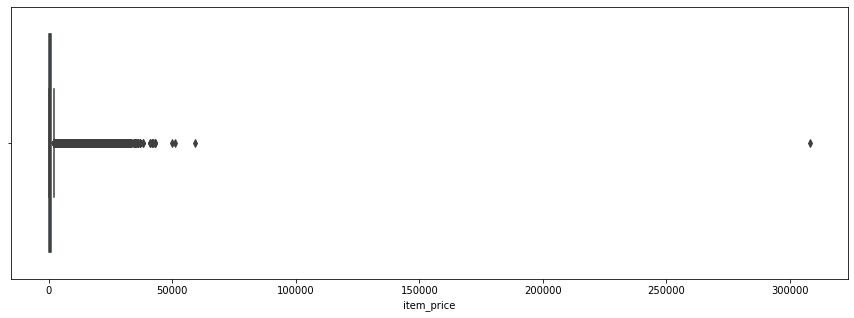

In [12]:
%%time
# checking for price
plt.figure(figsize=(15,5))
sns.boxplot(x=df_sales['item_price'])
print('Outliers for item_price : ', df_sales[df_sales['item_price']>55000]['item_price'].unique())
print('Outliers for item_price less than 0 : ', df_sales[df_sales['item_price']<=0]['item_price'].unique())

Wall time: 836 ms


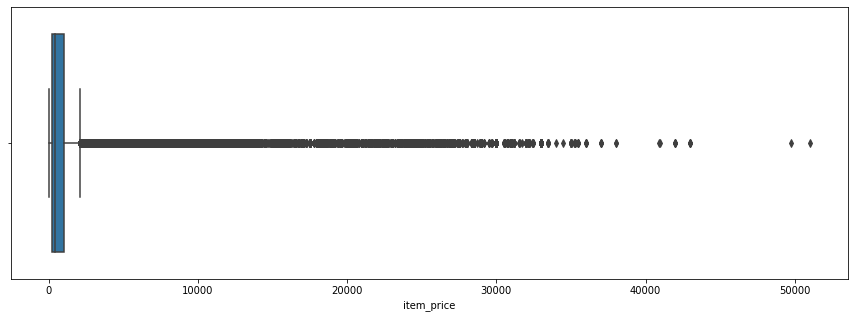

In [13]:
%%time
# values more than 55k could be outliers, so deleting all above 55k
df_sales = df_sales[df_sales['item_price']<= 55000]

#item price, should obviously not be less than 0 ... either it should be deleted or imputed.
df_sales = df_sales[df_sales['item_price'] > 0]

plt.figure(figsize=(15,5))
sns.boxplot(x=df_sales['item_price'])

### 3. Checking for possible duplications in Shops

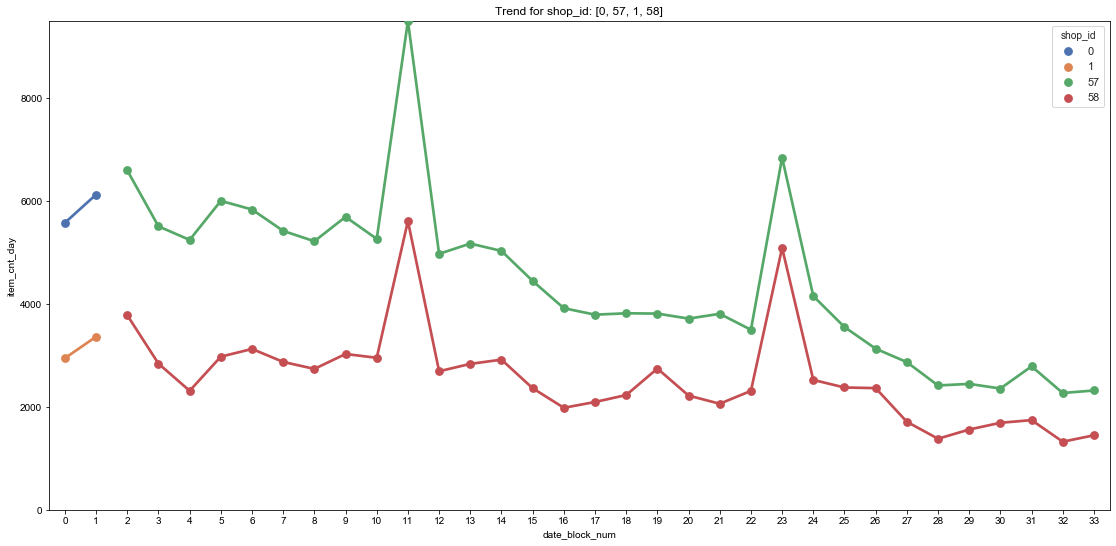

In [15]:
# using the fuzzy logic, I checked on the duplication of the similar shops.
# based on the similarity, certain shops have a 100 token set match. 
# I am performing the sales trend analysis on the similar shops
gb_shop = df_sales.groupby(['shop_id','date_block_num'], as_index=False)['item_cnt_day'].sum()
sales_util.plot_sales_trend([0,57,1,58],'shop_id', gb_shop)

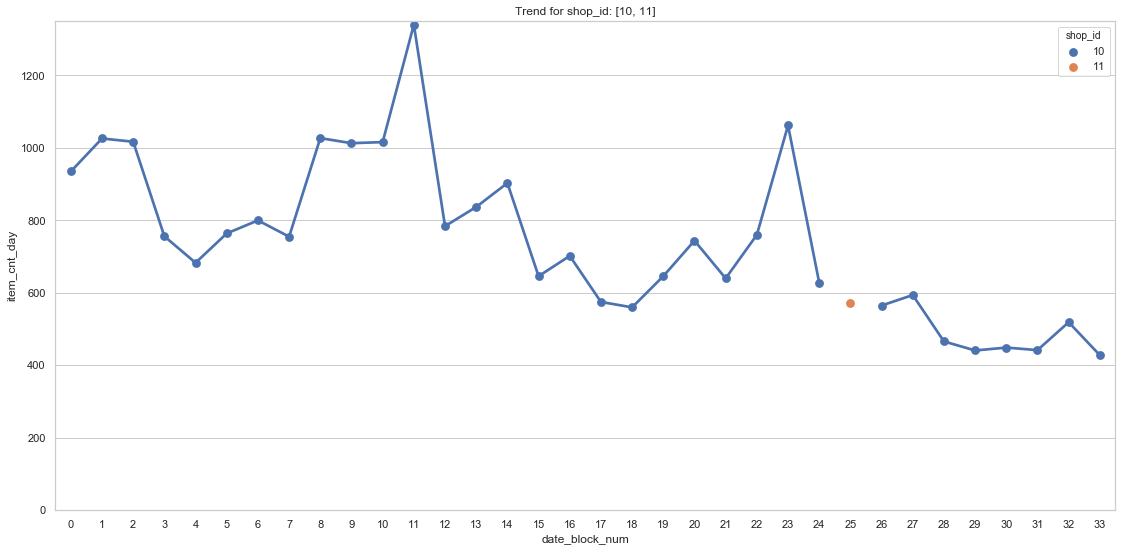

In [16]:
sales_util.plot_sales_trend([10,11],'shop_id', gb_shop)

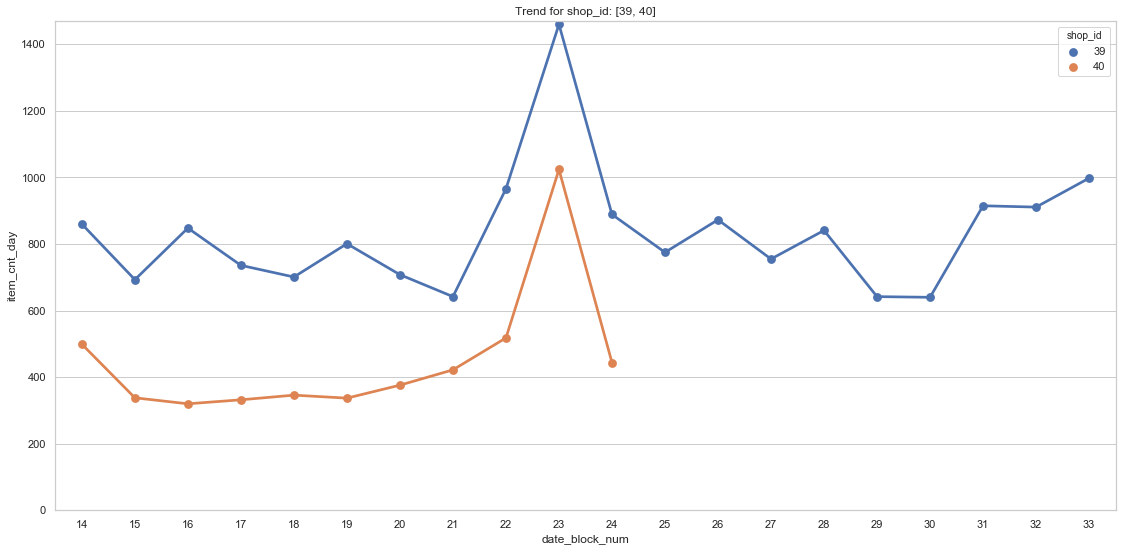

In [17]:
sales_util.plot_sales_trend([39,40],'shop_id', gb_shop)

In [18]:
# based on the above, duplicating as follows
df_sales['shop_id'].replace({0: 57, 1: 58, 11: 10, 40: 39}, inplace=True)

In [19]:
print('There are total of',df_shops.shop_id.nunique(),' shops, let us also examine if there are any outdated shops') 

There are total of 60  shops, let us also examine if there are any outdated shops


### 4. Checking for outdated Shops

We will check the availability of shops by months

In [20]:
avg_not_found = 0
overall_unique_shops = df_shops['shop_id'].unique()

for i in range(0, 34):
    block_unique_shops = df_sales[df_sales['date_block_num']==i]['shop_id'].unique() 
    diff = [shop for shop in overall_unique_shops if shop not in block_unique_shops]
    
    avg_not_found += len(diff)
    print(f'month-{i:02d} - {len(diff):02d} Shops not found  ... ' ,sorted(diff))
    
    
print('')
avg_not_found = avg_not_found/33
print(f'average {avg_not_found:2.2f} shops not available.')

month-00 - 15 Shops not found  ...  [0, 1, 5, 9, 11, 17, 20, 33, 34, 36, 39, 40, 48, 49, 55]
month-01 - 14 Shops not found  ...  [0, 1, 9, 11, 17, 20, 33, 34, 36, 39, 40, 48, 49, 55]
month-02 - 14 Shops not found  ...  [0, 1, 9, 11, 17, 20, 33, 34, 36, 39, 40, 48, 49, 55]
month-03 - 14 Shops not found  ...  [0, 1, 9, 11, 17, 20, 33, 34, 36, 39, 40, 48, 49, 55]
month-04 - 15 Shops not found  ...  [0, 1, 8, 9, 11, 17, 20, 23, 33, 34, 36, 39, 40, 48, 49]
month-05 - 14 Shops not found  ...  [0, 1, 8, 9, 11, 20, 23, 33, 34, 36, 39, 40, 48, 49]
month-06 - 14 Shops not found  ...  [0, 1, 8, 9, 11, 20, 23, 33, 34, 36, 39, 40, 48, 49]
month-07 - 15 Shops not found  ...  [0, 1, 8, 9, 11, 20, 23, 32, 33, 34, 36, 39, 40, 48, 49]
month-08 - 15 Shops not found  ...  [0, 1, 8, 9, 11, 20, 23, 32, 33, 34, 36, 39, 40, 48, 49]
month-09 - 14 Shops not found  ...  [0, 1, 8, 11, 20, 23, 32, 33, 34, 36, 39, 40, 48, 49]
month-10 - 15 Shops not found  ...  [0, 1, 8, 9, 11, 20, 23, 32, 33, 34, 36, 39, 40, 48, 4

**So, the shops that are not available for last 6 months are:**
    - 0, 1, 8, 11, 13, 17, 23, 29, 30,32, 33, 40, 43, 54
    
**We will clean our dataset by deleting these shops**    

In [21]:
outdated_shops = [0, 1, 8, 11, 13, 17, 23, 29, 30, 32, 33, 40, 43, 54]
df_sales = df_sales[df_sales['shop_id'].isin(outdated_shops)==False]

In [23]:
len(df_sales), len_sales, (len_sales-len(df_sales))

(2588876, 2935849, 346973)

### 5. Combining all Data-Sets to make one master for our Analysis

In [25]:
%%time

# Adding the date time attributes (like week day, month number, etc.)
df_sales = sales_util.add_date_attributes(df_sales)

# merging with the items, item_categories, shops
df_sales = sales_util.merge_sales_n_shops(DATA_FOLDER,df_sales)

Wall time: 6.36 s


In [27]:
len(df_sales), len_sales, (len_sales-len(df_sales))

(2588876, 2935849, 346973)

### 6. Checking for duplicated Item Categories

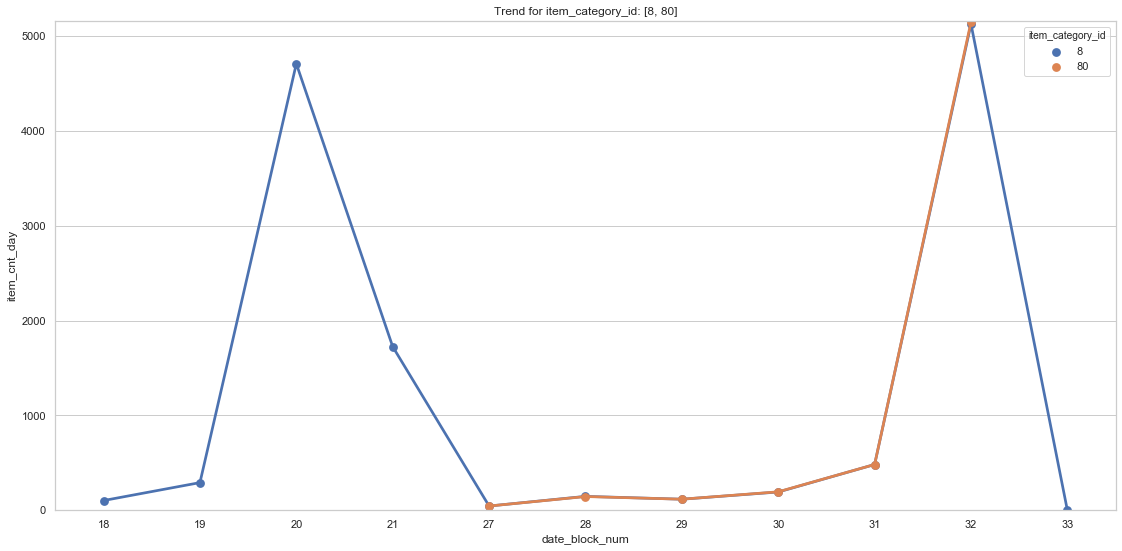

In [28]:
#based on the fuzzy match between the item categories, probing item categories 
gb_cat = df_sales.groupby(['item_category_id','date_block_num'], as_index=False)['item_cnt_day'].sum()
#comparing item_category_id 8 with 80
sales_util.plot_sales_trend([8,80],'item_category_id', gb_cat) 

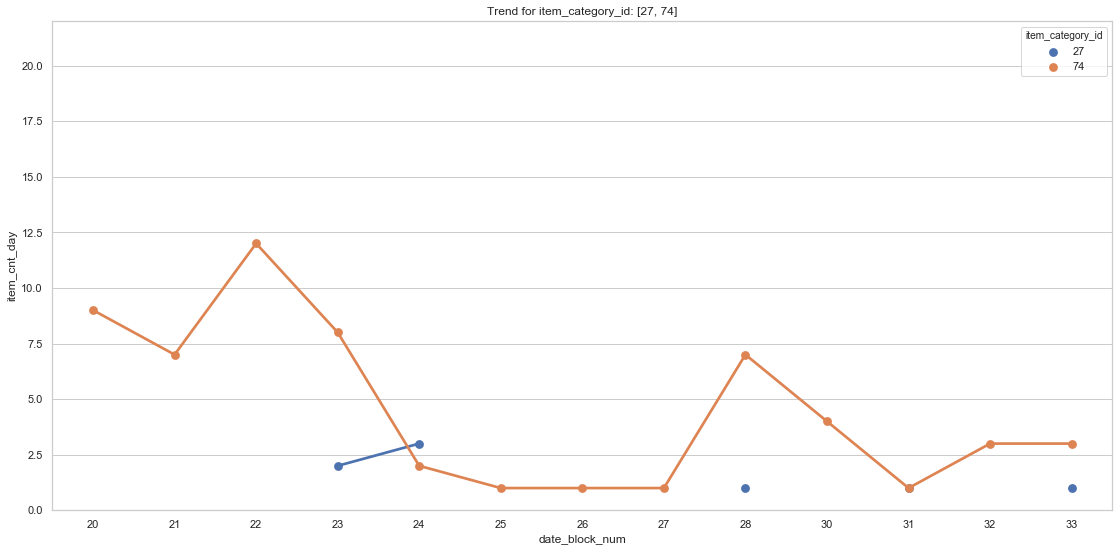

In [29]:
sales_util.plot_sales_trend([27,74],'item_category_id', gb_cat) 

In [30]:
df_sales['item_category_id'].replace({8: 80, 27: 74}, inplace=True)

### 7. Adding the public holidays to the dataset
* I have gathered all the public holidays from google for the company's country of origin 

In [31]:
%%time 

# adding the column
df_sales['is_holiday'] = 0

# adding 1 to the specified dates
holidays_list = ['1:1','1:25','2:15','2:27','3:25','4:21','4:26','4:27','6:6','6:8','8:6','8:12','8:27','9:13','9:29','10:1',
                '10:4','10:23','10:24','10:25','10:29','10:30','10:31','11:10','11:19','11:27','12:9','12:17']

for holiday in tqdm_notebook(holidays_list):
    
    # getting the holiday month and day
    m = holiday.split(':')[0] 
    d = holiday.split(':')[1]
    
    m = int(m)
    d = int(d)
    
    # getting the indexes for the holidays    
    dt = df_sales[(df_sales['day']==d) & (df_sales['month']==m)].index
    
    for idx in dt:
        # updating the sales data        
        df_sales.at[idx,'is_holiday'] = 1


Wall time: 7.79 s


In [32]:
print('total holidays in dataset are ', len(df_sales[df_sales['is_holiday']==1]))

total holidays in dataset are  184476


### 8. Getting the Revenue for each item

In [34]:
df_sales['revenue'] = df_sales['item_price'] * df_sales['item_cnt_day']

### 9. Down-casting

In [35]:
%%time
df_sales.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2588876 entries, 0 to 2588875
Data columns (total 18 columns):
 #   Column            Dtype         
---  ------            -----         
 0   date              datetime64[ns]
 1   date_block_num    int64         
 2   shop_id           int64         
 3   item_id           int64         
 4   item_price        float64       
 5   item_cnt_day      float64       
 6   day               int64         
 7   month             int64         
 8   weekday           object        
 9   weekdayno         int64         
 10  year              int64         
 11  item_category_id  int64         
 12  parent_cat_id     int32         
 13  parent_cat        object        
 14  city_id           int64         
 15  city_name         object        
 16  is_holiday        int64         
 17  revenue           float64       
dtypes: datetime64[ns](1), float64(3), int32(1), int64(10), object(3)
memory usage: 816.4 MB
Wall time: 34.8 s


In [38]:
%%time
# down casting
df_sales['date_block_num'] = df_sales['date_block_num'].astype('int8')
df_sales['shop_id'] = df_sales['shop_id'].astype('int8')
df_sales['item_id'] = df_sales['item_id'].astype('int16')
df_sales['item_price'] = df_sales['item_price'].astype('float16')
df_sales['item_cnt_day'] = df_sales['item_cnt_day'].astype('int16')
df_sales['revenue'] = df_sales['revenue'].astype('float32')
df_sales['day'] = df_sales['day'].astype('int8')
df_sales['month'] = df_sales['month'].astype('int8')
df_sales['weekdayno'] = df_sales['weekdayno'].astype('int8')
df_sales['year'] = df_sales['year'].astype('int16')
df_sales['item_category_id'] = df_sales['item_category_id'].astype('int8')
df_sales['parent_cat_id'] = df_sales['parent_cat_id'].astype('int8')
df_sales['parent_cat_id'] = df_sales['parent_cat_id'].astype('int8')
df_sales['is_holiday'] = df_sales['is_holiday'].astype('int8')
df_sales['city_id'] = df_sales['city_id'].astype('int8')

# as we have number representations for both of the below, they will be deleted after eda
df_sales['weekday'] = df_sales['weekday'].astype('category')
df_sales['parent_cat'] = df_sales['parent_cat'].astype('category')
df_sales['city_name'] = df_sales['city_name'].astype('category')

Wall time: 2.45 s


In [39]:
%%time
df_sales.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2588876 entries, 0 to 2588875
Data columns (total 18 columns):
 #   Column            Dtype         
---  ------            -----         
 0   date              datetime64[ns]
 1   date_block_num    int8          
 2   shop_id           int8          
 3   item_id           int16         
 4   item_price        float16       
 5   item_cnt_day      int16         
 6   day               int8          
 7   month             int8          
 8   weekday           category      
 9   weekdayno         int8          
 10  year              int16         
 11  item_category_id  int8          
 12  parent_cat_id     int8          
 13  parent_cat        category      
 14  city_id           int8          
 15  city_name         category      
 16  is_holiday        int8          
 17  revenue           float32       
dtypes: category(3), datetime64[ns](1), float16(1), float32(1), int16(3), int8(9)
memory usage: 98.8 MB
Wall time: 86 ms


In [31]:
len(df_sales), len_sales

(2592561, 2935849)

##### we saved huge memory !!

In [40]:
df_sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,weekday,weekdayno,year,item_category_id,parent_cat_id,parent_cat,city_id,city_name,is_holiday,revenue
0,2013-01-02,0,59,22154,999.0,1,2,1,Wednesday,2,2013,37,6,cinema,29,Yaroslavl,0,999.0
1,2013-05-16,4,59,2573,249.0,1,16,5,Thursday,3,2013,55,13,music,29,Yaroslavl,0,249.0
2,2013-01-26,0,59,2574,399.0,1,26,1,Saturday,5,2013,55,13,music,29,Yaroslavl,0,399.0
3,2013-01-09,0,59,2574,399.0,1,9,1,Wednesday,2,2013,55,13,music,29,Yaroslavl,0,399.0
4,2013-02-24,1,59,2574,399.0,1,24,2,Sunday,6,2013,55,13,music,29,Yaroslavl,0,399.0


### 10. Save the Merged (Categories, Sales, Shops) Records
EDA will be performed on this data set

In [42]:
df_sales.to_csv(os.path.join(DATA_FOLDER, 'sales_by_day_cleaned.csv'), index=False)

### 11. performing the same operations with TEST dataset

In [43]:
%%time
#1. test data frame, adding date_block_num and month
df_test['date_block_num'] = 34
df_test['month'] = 11

#2. merging, just like the sales
df_test = sales_util.merge_sales_n_shops(DATA_FOLDER,df_test)

#3. duplicate category id
df_test['item_category_id'].replace({8: 80, 27: 74, 75: 76}, inplace=True)

Wall time: 265 ms


In [44]:
len_test, len(df_test)

(214200, 214200)

In [45]:
# saving the test 
df_test.to_csv(os.path.join(DATA_FOLDER, 'test_data_cleaned.csv'), index=False)
gc.collect()

56703

In [37]:
del df_sales,df_test,df_items,df_shops,df_item_categories